## 데이터  
- CITYSCAPES 데이터셋  
- aachen (174), bochum (96), bremen (316), cologne (154), darmstadt (85), hamburg (248), hanover (196), strasbourg (365), zurich (122)  
- **Strasbourg** 지역 대상으로 수집된 365 개의 샘플을 사용해 학습

In [127]:
import os

import torch
from torch.nn import functional as F
import torchvision as tv

import numpy as np

import matplotlib.pyplot as plt

In [122]:
RANDOM_SEED = 42
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 4
NUM_CLASS   = 34
EPOCHS      = 10

DEVICE = torch.device('cpu')

ROOT_PATH = 'C:/Users/bkk11/Desktop/DATA/CITYSCAPES'
MODEL_SAVE = False
if MODEL_SAVE: MODEL_SAVE_PATH = './FCN.pth'
INPUT_PATH = os.path.join(ROOT_PATH, 'leftImg8bit')
LABEL_PATH = os.path.join(ROOT_PATH, 'gtFine')

print(INPUT_PATH)
print(LABEL_PATH)

C:/Users/bkk11/Desktop/DATA/CITYSCAPES\leftImg8bit
C:/Users/bkk11/Desktop/DATA/CITYSCAPES\gtFine


In [3]:
INPUT_PATH_train = sorted(os.listdir(os.path.join(INPUT_PATH, 'train', 'strasbourg')))
LABEL_PATH_train = sorted([x for x in os.listdir(os.path.join(LABEL_PATH, 'train', 'strasbourg')) if 'labelIds' in x])

INPUT_PATH_val = sorted(os.listdir(os.path.join(INPUT_PATH, 'val', 'frankfurt')))
LABEL_PATH_val = sorted([x for x in os.listdir(os.path.join(LABEL_PATH, 'val', 'frankfurt')) if 'labelIds' in x])

INPUT_PATH_test = sorted(os.listdir(os.path.join(INPUT_PATH, 'test', 'berlin')))
LABEL_PATH_test = sorted([x for x in os.listdir(os.path.join(LABEL_PATH, 'test', 'berlin')) if 'labelIds' in x])

print(len(INPUT_PATH_train), INPUT_PATH_train[: 1], LABEL_PATH_train[: 1])
print(len(INPUT_PATH_val  ), INPUT_PATH_val[  : 1], LABEL_PATH_val[  : 1])
print(len(INPUT_PATH_test ), INPUT_PATH_test[ : 1], LABEL_PATH_test[ : 1])

365 ['strasbourg_000000_000065_leftImg8bit.png'] ['strasbourg_000000_000065_gtFine_labelIds.png']
267 ['frankfurt_000000_000294_leftImg8bit.png'] ['frankfurt_000000_000294_gtFine_labelIds.png']
544 ['berlin_000000_000019_leftImg8bit.png'] ['berlin_000000_000019_gtFine_labelIds.png']


In [10]:
X_train = list(map(lambda x: os.path.join(INPUT_PATH, 'train', 'strasbourg', x), INPUT_PATH_train))
y_train = list(map(lambda x: os.path.join(LABEL_PATH, 'train', 'strasbourg', x), LABEL_PATH_train))

X_val = list(map(lambda x: os.path.join(INPUT_PATH, 'val', 'frankfurt', x), INPUT_PATH_val))
y_val = list(map(lambda x: os.path.join(LABEL_PATH, 'val', 'frankfurt', x), LABEL_PATH_val))

X_test = list(map(lambda x: os.path.join(INPUT_PATH, 'test', 'berlin', x), INPUT_PATH_test))
y_test = list(map(lambda x: os.path.join(LABEL_PATH, 'test', 'berlin', x), LABEL_PATH_test))

print(X_train[: 1], y_train[: 1])
print(X_val[  : 1], y_val[  : 1])
print(X_test[ : 1], y_test[ : 1])

['C:/Users/bkk11/Desktop/DATA/CITYSCAPES\\leftImg8bit\\train\\strasbourg\\strasbourg_000000_000065_leftImg8bit.png'] ['C:/Users/bkk11/Desktop/DATA/CITYSCAPES\\gtFine\\train\\strasbourg\\strasbourg_000000_000065_gtFine_labelIds.png']
['C:/Users/bkk11/Desktop/DATA/CITYSCAPES\\leftImg8bit\\val\\frankfurt\\frankfurt_000000_000294_leftImg8bit.png'] ['C:/Users/bkk11/Desktop/DATA/CITYSCAPES\\gtFine\\val\\frankfurt\\frankfurt_000000_000294_gtFine_labelIds.png']
['C:/Users/bkk11/Desktop/DATA/CITYSCAPES\\leftImg8bit\\test\\berlin\\berlin_000000_000019_leftImg8bit.png'] ['C:/Users/bkk11/Desktop/DATA/CITYSCAPES\\gtFine\\test\\berlin\\berlin_000000_000019_gtFine_labelIds.png']


In [14]:
samplex = tv.io.read_image(X_train[0])
sampley = tv.io.read_image(y_train[0])

print(samplex.shape, samplex.dtype)
print(sampley.shape, sampley.dtype, np.unique(sampley))

torch.Size([3, 1024, 2048]) torch.uint8
torch.Size([1, 1024, 2048]) torch.uint8 [ 0  1  2  3  4  6  7  8 11 17 20 21 22 23 26 33]


In [144]:
X_train_trans = tv.models.VGG16_Weights.IMAGENET1K_FEATURES.transforms()
y_train_trans = tv.transforms.Compose([
    tv.transforms.Resize(size = 256, interpolation = tv.transforms.InterpolationMode.NEAREST),
    tv.transforms.CenterCrop(size = IMG_SIZE)
])

X_val_trans = tv.models.VGG16_Weights.IMAGENET1K_FEATURES.transforms()
y_val_trans = tv.transforms.Compose([
    tv.transforms.Resize(size = 256, interpolation = tv.transforms.InterpolationMode.NEAREST),
    tv.transforms.CenterCrop(size = IMG_SIZE)
])

print(X_train_trans)
print(y_train_trans)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.48235, 0.45882, 0.40784]
    std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098]
    interpolation=InterpolationMode.BILINEAR
)
Compose(
    Resize(size=256, interpolation=nearest, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
)


In [145]:
class DataLoader(torch.utils.data.Dataset):
    def __init__(self, img_path, img_labels, transforms_x = None, transforms_y = None):
        self.img_path     = img_path
        self.img_labels   = img_labels
        self.transforms_x = transforms_x
        self.transforms_y = transforms_y
        
    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self, index):
        x = tv.io.read_image(self.img_path[index]) / 255.
        y = tv.io.read_image(self.img_labels[index]).to(torch.int64)
        
        if self.transforms_x: x = self.transforms_x(x)
        if self.transforms_y: y = self.transforms_y(y)
        
        return x, y

In [154]:
train_dataset = DataLoader(X_train, y_train, transforms_x = X_train_trans, transforms_y = y_train_trans)
val_dataset   = DataLoader(X_val  , y_val  , transforms_x = X_val_trans  , transforms_y = y_val_trans  )
test_dataset  = DataLoader(X_test , y_test , transforms_x = X_val_trans  , transforms_y = y_val_trans  )

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True , num_workers = 0)
val_loader   = torch.utils.data.DataLoader(val_dataset  , batch_size = 1         , shuffle = False, num_workers = 0)
test_loader  = torch.utils.data.DataLoader(test_dataset , batch_size = 1         , shuffle = False, num_workers = 0)

sample_X_train, sample_y_train = next(iter(train_loader))
print(f'sample_X_train.shape   : {sample_X_train.shape}')
print(f'sample_X_train.dtype   : {sample_X_train.dtype}')
print(f'sample_X_train.min, max: {torch.min(sample_X_train), torch.max(sample_X_train)}')
print(f'sample_y_train.shape   : {sample_y_train.shape}')
print(f'sample_y_train.dtype   : {sample_y_train.dtype}')
print(f'sample_y_train.unique  : {np.unique(sample_y_train)}')

sample_X_train.shape   : torch.Size([4, 3, 224, 224])
sample_X_train.dtype   : torch.float32
sample_X_train.min, max: (tensor(-100.7492), tensor(151.0008))
sample_y_train.shape   : torch.Size([4, 1, 224, 224])
sample_y_train.dtype   : torch.int64
sample_y_train.unique  : [ 1  4  6  7  8  9 10 11 12 13 17 19 20 21 23 24 25 26 33]


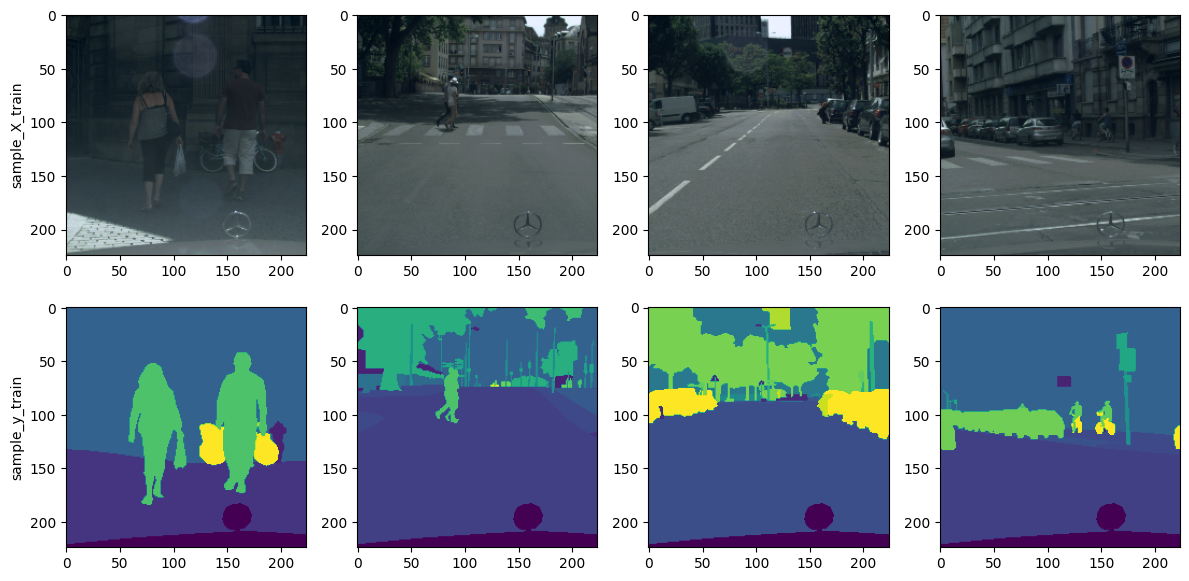

In [155]:
ncols, nrows = 4, 2
fig, subs = plt.subplots(ncols = ncols, nrows = nrows, figsize = (3 * ncols, 3 * nrows))
for i in range(ncols):
    img0 = sample_X_train[i].permute(1, 2, 0)
    img1 = sample_y_train[i].permute(1, 2, 0)[:, :, 0]
    
    subs[0, i].imshow((img0 - img0.min()) / (img0.max() - img0.min()))
    subs[0, 0].set_ylabel('sample_X_train')
    
    subs[1, i].imshow(img1)
    subs[1, 0].set_ylabel('sample_y_train')
    
plt.tight_layout()
plt.show()

In [ ]:
ranges = {'vgg16' : ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))}
